In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import operator
import copy
import random
from sklearn import model_selection
import sparse_bag_tools as spt
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from user_based import user_based_CF
from item_based import item_CF
from matrix_factorization import matrix_factor
sns.set(color_codes=True)

%matplotlib inline
raw_games = pd.read_csv("steam-200k.csv", names =["user_id", "game", "behavior", "value", "misc."])
playtime = raw_games[raw_games["behavior"] == "play" ]
purchased = raw_games[raw_games["behavior"] == "purchase" ]

In [2]:
bag = spt.bag_of_games(playtime)
proc_bag = spt.preprocessing(bag)
log_bag = spt.norm(proc_bag)
split = spt.leave_n_in

In [3]:
train_bag, test_points = split(log_bag, 1, .25)

In [4]:
base_powers = np.arange(-2.0, 2, .1)
base_MAEs = []
base_RMSEs = []
for power in base_powers:
    reg = 10**power
    model = spt.Baseline(reg)
    model = model.fit(train_bag)
    predictions = model.predict(test_points)
    scores = spt.get_metrics(test_points, predictions)
    base_MAEs.append(scores[0])
    base_RMSEs.append(scores[1])

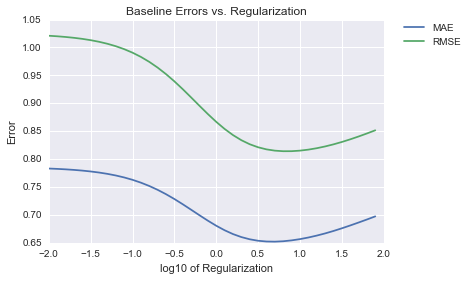

In [5]:
plt.title("Baseline Errors vs. Regularization")
plt.ylabel("Error")
plt.xlabel("log10 of Regularization")
plt.plot(base_powers, base_MAEs, label = "MAE")
plt.plot(base_powers, base_RMSEs, "g", label = "RMSE")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("baseline_reg.jpg")

In [6]:
base_MAE_reg = 10**base_powers[np.argmin(np.array(base_MAEs))]
base_RMSE_reg =10**base_powers[np.argmin(np.array(base_RMSEs))]
base_MAE_reg, base_RMSE_reg

(5.0118723362727504, 6.3095734448019689)

In [7]:
base_MAE_best = np.min(np.array(base_MAEs))
base_RMSE_best = np.min(np.array(base_RMSEs))
base_MAE_best, base_RMSE_best

(0.65197160767958295, 0.81404778818925505)

In [8]:
ub = user_based_CF(train_bag)
ub.fit()

Fitting Start!!!

Fitting Progress:0.3333333333333333

Fitting Progress:0.5988023881659765

Fitting Progress:0.6993006916842662

Fitting Progress:0.7999999651472023

Fitting Progress:0.9009008620447413

Fitting Complete!!!



In [9]:
user_MAE = []
user_RMSE = []
user_ks = np.arange(4, 13)
for k in user_ks:
    pred = ub.predict(test_points, 2**k)
    mae, rmse = spt.get_metrics(test_points, pred)
    user_MAE.append(mae)
    user_RMSE.append(rmse)

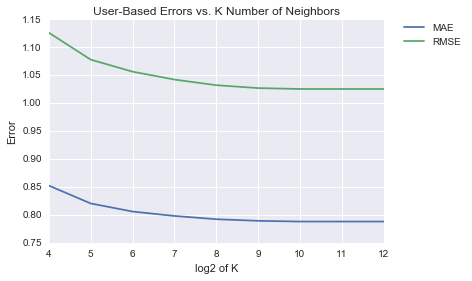

In [10]:
plt.title("User-Based Errors vs. K Number of Neighbors")
plt.ylabel("Error")
plt.xlabel("log2 of K")
plt.plot(user_ks, user_MAE, label = "MAE")
plt.plot(user_ks, user_RMSE, "g", label = "RMSE")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("user_k.jpg")

In [11]:
user_MAE_k = 2**user_ks[np.argmin(np.array(user_MAE))]
user_RMSE_k =2**user_ks[np.argmin(np.array(user_RMSE))]

In [12]:
user_MAE_best = np.min(np.array(user_MAE))
user_RMSE_best = np.min(np.array(user_RMSE))

In [13]:
user_MAE_k, user_RMSE_k

(1024, 1024)

In [14]:
user_MAE_best, user_RMSE_best

(0.78808766172951039, 1.0256800467524099)

In [15]:
ib = item_CF()
ib = ib.fit(train_bag)

In [16]:
item_MAE = []
item_RMSE = []
item_ks = np.arange(11)
for k in item_ks:
    pred = ib.predict(test_points, 2**k)
    mae, rmse = spt.get_metrics(test_points, pred)
    item_MAE.append(mae)
    item_RMSE.append(rmse)

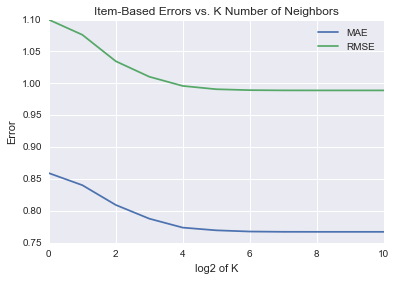

In [17]:
plt.title("Item-Based Errors vs. K Number of Neighbors")
plt.ylabel("Error")
plt.xlabel("log2 of K")
plt.plot(item_ks, item_MAE, label = "MAE")
plt.plot(item_ks, item_RMSE, "g", label = "RMSE")
plt.legend()
plt.savefig("item_k.jpg")

In [18]:
item_MAE_k = 2**item_ks[np.argmin(np.array(item_MAE))]
item_RMSE_k = 2**item_ks[np.argmin(np.array(item_RMSE))]
item_MAE_k, item_RMSE_k

(512, 512)

In [19]:
item_powers = np.arange(-2.0, 2, .1)
item_MAEs = []
item_RMSEs = []
for power in item_powers:
    reg = 10**power
    predictions = ib.predict(test_points, k = item_RMSE_k, reg = reg)
    scores = spt.get_metrics(test_points, predictions)
    item_MAEs.append(scores[0])
    item_RMSEs.append(scores[1])

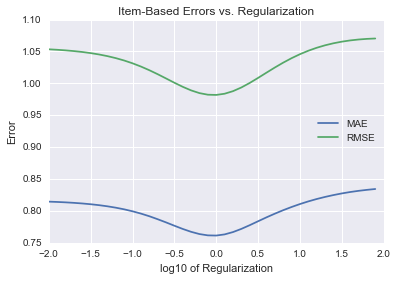

In [20]:
plt.title("Item-Based Errors vs. Regularization")
plt.ylabel("Error")
plt.xlabel("log10 of Regularization")
plt.plot(item_powers, item_MAEs, label = "MAE")
plt.plot(item_powers, item_RMSEs, "g", label = "RMSE")
plt.legend(loc=5)
plt.savefig("item_reg.jpg")

In [21]:
item_MAE_reg = 10**item_powers[np.argmin(np.array(item_MAEs))]
item_RMSE_reg = 10**item_powers[np.argmin(np.array(item_RMSEs))]
item_MAE_reg, item_RMSE_reg

(1.000000000000004, 1.000000000000004)

In [22]:
item_MAE_best = min(item_MAEs)
item_RMSE_best = min(item_RMSEs)
item_MAE_best, item_RMSE_best

(0.76130708097320776, 0.98180887002990691)

In [23]:
als = matrix_factor(k = 5, method = "als")
als = als.fit(train_bag, steps = 30)

sgd = matrix_factor(k = 5, method = "sgd")
sgd = sgd.fit(train_bag, steps = 30, alpha = 0.01)

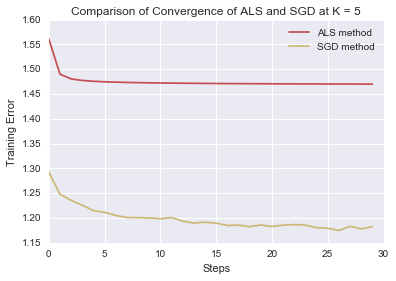

In [24]:
plt.plot(np.array(als.errs)**.5, "r", label = "ALS method")
plt.plot(np.array(sgd.errs)**.5, "y", label = "SGD method")
plt.ylabel("Training Error")
plt.xlabel("Steps")
plt.title("Comparison of Convergence of ALS and SGD at K = 5")
plt.legend()
plt.savefig("matrix_factor_comparison.jpg")

In [25]:
als_MAEs = []
als_RMSEs = []
als_ks = np.arange(1, 40)
for k in als_ks:
    mf_als = matrix_factor(k, "als")
    mf_als = mf_als.fit(train_bag, steps = 5)
    predictions = mf_als.predict(test_points)
    scores = spt.get_metrics(test_points, predictions)
    als_MAEs.append(scores[0])
    als_RMSEs.append(scores[1])

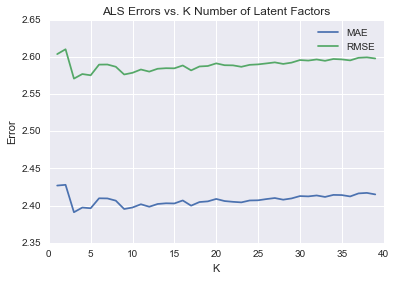

In [26]:
plt.title("ALS Errors vs. K Number of Latent Factors")
plt.ylabel("Error")
plt.xlabel("K")
plt.plot(als_ks, als_MAEs, label = "MAE")
plt.plot(als_ks, als_RMSEs, "g", label = "RMSE")
plt.legend(loc = 0)
plt.savefig("als_k.jpg")

In [27]:
als_MAE_k = als_ks[np.argmin(np.array(als_MAEs))]
als_RMSE_k = als_ks[np.argmin(np.array(als_RMSEs))]
als_MAE_k, als_RMSE_k

(3, 3)

In [28]:
als_MAEs = []
als_RMSEs = []
als_powers = np.arange(-2.0, 2, .1)
for power in als_powers:
    reg  = 10**power
    mf_als = matrix_factor(k = als_RMSE_k, method = "als")
    mf_als = mf_als.fit(train_bag, steps = 5, beta = reg)
    predictions = mf_als.predict(test_points)
    scores = spt.get_metrics(test_points, predictions)
    als_MAEs.append(scores[0])
    als_RMSEs.append(scores[1])

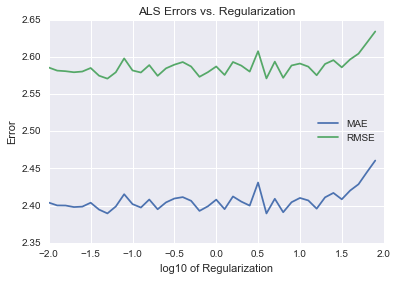

In [29]:
plt.title("ALS Errors vs. Regularization")
plt.ylabel("Error")
plt.xlabel("log10 of Regularization")
plt.plot(als_powers, als_MAEs, label = "MAE")
plt.plot(als_powers, als_RMSEs, "g", label = "RMSE")
plt.legend(loc=5)
plt.savefig("als_reg.jpg")

In [30]:
als_MAE_reg = 10**als_powers[np.argmin(np.array(als_MAEs))]
als_RMSE_reg = 10**als_powers[np.argmin(np.array(als_RMSEs))]
als_MAE_reg, als_RMSE_reg

(3.9810717055349936, 0.050118723362727303)

In [31]:
als_MAE_best = min(als_MAEs)
als_RMSE_best = min(als_RMSEs)
als_MAE_best, als_RMSE_best

(2.3893756486485245, 2.5705969695767381)

In [32]:
sgd_MAEs = []
sgd_RMSEs = []
sgd_ks = np.arange(5, 51, 5)
for k in sgd_ks:
    mf_sgd = matrix_factor(k, "sgd")
    mf_sgd = mf_sgd.fit(train_bag, steps = 10, alpha = 0.01)
    predictions = mf_sgd.predict(test_points)
    scores = spt.get_metrics(test_points, predictions)
    sgd_MAEs.append(scores[0])
    sgd_RMSEs.append(scores[1])

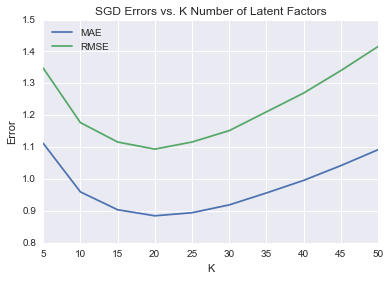

In [33]:
plt.title("SGD Errors vs. K Number of Latent Factors")
plt.ylabel("Error")
plt.xlabel("K")
plt.plot(sgd_ks, sgd_MAEs, label = "MAE")
plt.plot(sgd_ks, sgd_RMSEs, "g", label = "RMSE")
plt.legend(loc = 0)
plt.savefig("sgd_k.jpg")

In [34]:
sgd_MAE_k = sgd_ks[np.argmin(np.array(sgd_MAEs))]
sgd_RMSE_k = sgd_ks[np.argmin(np.array(sgd_RMSEs))]
sgd_MAE_k, sgd_RMSE_k

(20, 20)

In [45]:
sgd_MAEs = []
sgd_RMSEs = []
sgd_powers = np.arange(-2.0, 2, .1)
for power in sgd_powers:
    reg  = 10**power
    mf_sgd = matrix_factor(k = als_RMSE_k, method = "sgd")
    mf_sgd = mf_sgd.fit(train_bag, steps = 10, beta = reg, alpha = 0.01)
    predictions = mf_sgd.predict(test_points)
    scores = spt.get_metrics(test_points, predictions)
    sgd_MAEs.append(scores[0])
    sgd_RMSEs.append(scores[1])

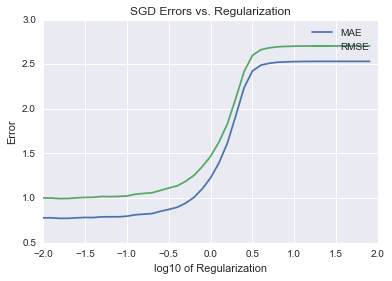

In [46]:
plt.title("SGD Errors vs. Regularization")
plt.ylabel("Error")
plt.xlabel("log10 of Regularization")
plt.plot(sgd_powers, sgd_MAEs, label = "MAE")
plt.plot(sgd_powers, sgd_RMSEs, "g", label = "RMSE")
plt.legend(loc=1)
plt.savefig("sgd_reg.jpg")

In [47]:
sgd_MAE_reg = 10**sgd_powers[np.argmin(np.array(sgd_MAEs))]
sgd_RMSE_reg = 10**sgd_powers[np.argmin(np.array(sgd_RMSEs))]
sgd_MAE_reg, sgd_RMSE_reg

(0.015848931924611141, 0.015848931924611141)

In [48]:
sgd_MAE_best = min(sgd_MAEs)
sgd_RMSE_best = min(sgd_RMSEs)
sgd_MAE_best, sgd_RMSE_best

(0.77302990561342244, 0.99413340962281693)

In [49]:
MAEs = [base_MAE_best, user_MAE_best, item_MAE_best, als_MAE_best, sgd_MAE_best]
RMSEs = [base_RMSE_best, user_RMSE_best, item_RMSE_best, als_RMSE_best, sgd_RMSE_best]
models = ["Baseline", "User Based CF", "Item Based CF",
          "Matrix Factorization ALS", "Matrix Factorization SGD"]

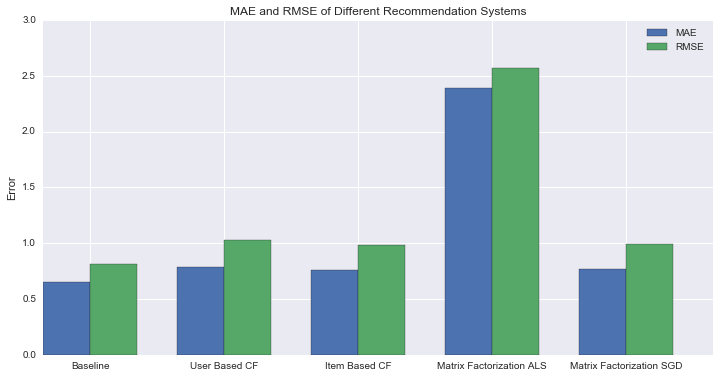

In [50]:
ind = np.arange(5)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(ind, MAEs, width, color='b')
rects2 = ax.bar(ind + width, RMSEs, width, color='g')

ax.set_ylabel('Error')
ax.set_title('MAE and RMSE of Different Recommendation Systems')
ax.set_xticks(ind + width )
ax.set_xticklabels(models)
ax.legend((rects1[0], rects2[0]), ('MAE', 'RMSE'))
fig.savefig("models.jpg")

In [41]:
class old_item_CF():
    def __init__(self, k = 2):
        self.k = k
        self.fitted = False
    
    
    def dict_NN(self, query):
        dists = [(key, abs(self.get_sim(key, query))) 
                 for key in self.item_bag.keys() if key != query]
        dists.sort(key=lambda pair: pair[1], reverse=True)
        self.neighborhood[query] = [pair[0] for pair in dists]
    
    def fit(self, train_bag):
        self.train_bag = train_bag
        self.item_bag  = spt.sparse_bag_transpose(train_bag)
        self.neighborhood = {}
        self.sims = {}
        item_list = list(self.item_bag.keys())
        for item in self.item_bag.keys():
            i = self.item_bag[item]
            item_list.remove(item)
            self.sims[item] = {k : spt.cos_sim(i, self.item_bag[k]) for k in item_list}
        self.fitted = True
        return self
    
    
    def get_sim(self, item_1 , item_2):
        if item_1 not in self.sims.keys():
            return 0.0
        elif item_2 not in self.sims.keys():
            return 0.0
        else:
            try:
                return self.sims[item_1][item_2]
            except KeyError:
                return self.sims[item_2][item_1]
    
    def predict(self, test_points, k = None):
        
        if not self.fitted:
            raise RuntimeError("You must train filter before predicting data!")
        
        if not k:
            k = self.k
        predictions = {}
        for pair in test_points:
            user = pair[0]
            item = pair[1]
            if item not in self.neighborhood.keys():
                if item not in self.item_bag.keys():
                    knn = []
                else:
                    self.dict_NN(item)
                    knn = (self.neighborhood[item])
                    
            else:
                if item not in self.item_bag.keys():
                    knn = []
                else:
                    knn = (self.neighborhood[item])
                
                    
            overlap = list(set(knn) & set(list(self.train_bag[user].keys())))
            if len(overlap) >= k:
                N = overlap[:k]
            else:
                N = overlap
                
                
            num = sum([self.get_sim(item, n)*(self.train_bag[user][n]) for n in N])
            den = sum([abs(self.get_sim(item, d)) for d in N])
            
            if 0.0 in (num, den):
                predictions[pair] = 0
            else:
                predictions[pair] = (num/den) 
            
        return predictions

In [42]:
new_ib = item_CF()
new_ib = new_ib.fit(train_bag)
old_ib = old_item_CF()
old_ib  = old_ib.fit(train_bag) 

In [43]:
new_item_MAE = []
new_item_RMSE = []
old_item_MAE = []
old_item_RMSE = []
item_ks = np.arange(11)
for k in item_ks:
    new_pred = new_ib.predict(test_points, 2**k, 0)
    old_pred = old_ib.predict(test_points, 2**k)
    new_mae, new_rmse = spt.get_metrics(test_points, new_pred)
    old_mae, old_rmse = spt.get_metrics(test_points, old_pred)
    new_item_MAE.append(new_mae)
    new_item_RMSE.append(new_rmse)
    old_item_MAE.append(old_mae)
    old_item_RMSE.append(old_rmse)

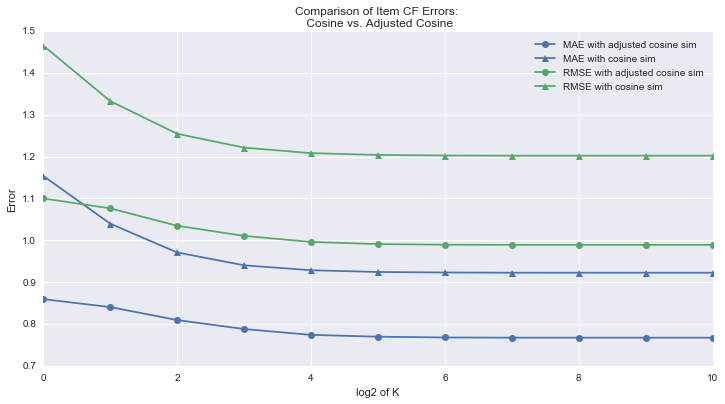

In [44]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plt.plot(item_ks, new_item_MAE, "bo-", label = "MAE with adjusted cosine sim")
plt.plot(item_ks, old_item_MAE, "b^-", label = "MAE with cosine sim")
plt.plot(item_ks, new_item_RMSE, "go-", label = "RMSE with adjusted cosine sim")
plt.plot(item_ks, old_item_RMSE, "g^-", label = "RMSE with cosine sim")
plt.legend(loc="upper right")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])

plt.title("Comparison of Item CF Errors: \n Cosine vs. Adjusted Cosine")
plt.ylabel("Error")
plt.xlabel("log2 of K")
fig.savefig("old_vs_new_itemCF.jpg")